# dino_trainer

Adapted from "Training a Classifier on Top of Dinov2 Features" by Niki Amini-Naieni

In [3]:
# Import modules.
import glob
import numpy as np
import torch
import torchvision.transforms as T
from torchvision import datasets
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F

import os

In [4]:
#define directories and model name
input_dir = '/scratch/local/ssd/hani/RepeatVeryNoisy'
model_name = 'RepeatVeryNoisy'
output_dir = 'models'

In [5]:
# Load DINOv2 model.
dinov2_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dinov2_vits14.to(device)
transform_image = T.Compose([
    T.ToTensor(),
    T.Resize(256),
    T.CenterCrop(224),
    T.Normalize(mean=[0.485, 0.456, 0.406], ###
                std=[0.229, 0.224, 0.225])
])

Using cache found in /users/hani/.cache/torch/hub/facebookresearch_dinov2_main
/users/hani/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/users/hani/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/users/hani/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0105634015..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.41992712..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.069708526..1.0].


getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item
getting item


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.25381917..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06908019..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3589859..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.09140224..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.009018107..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07310298..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06429967..1.0].
Clipping input data 

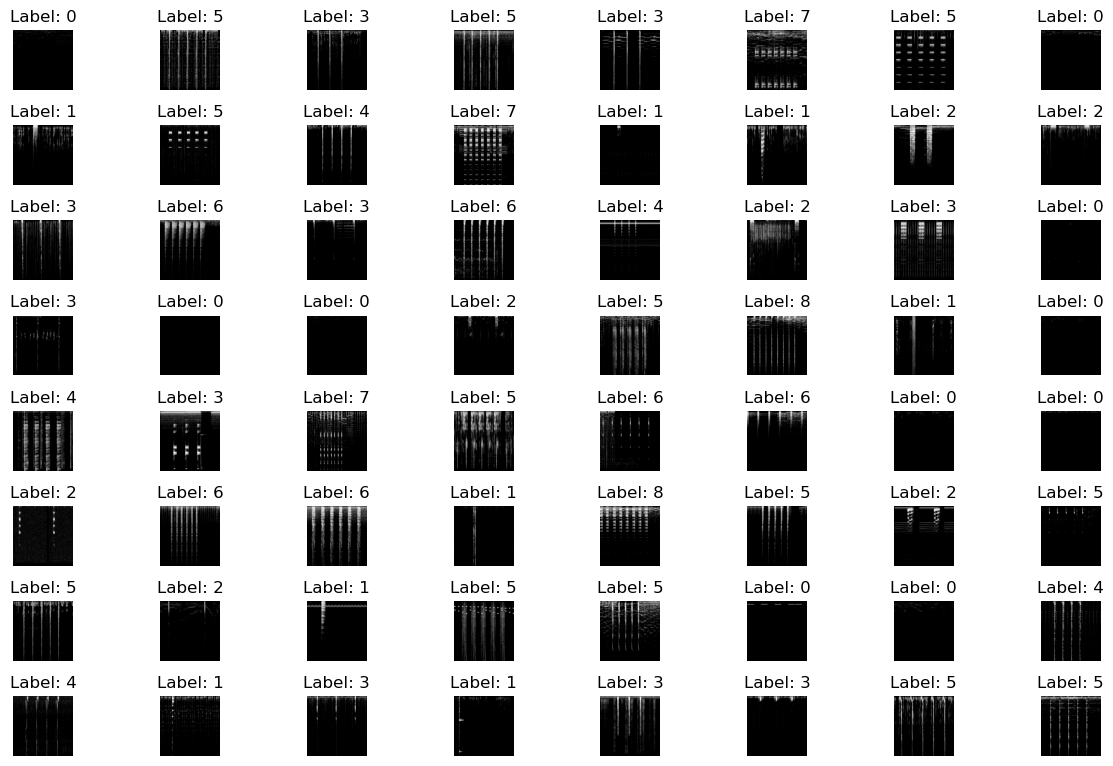

In [6]:
# Load spec data.
batch_size = 64

transform = T.Compose([
    T.Resize((224,224)),  # only if not already 224x224
])

class SpectrogramNPYDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.files = sorted([f for f in os.listdir(root_dir)
                             if f.endswith(".npy") and
                             os.path.getsize(os.path.join(root_dir, f)) > 0]) ###
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        arr = np.load(os.path.join(self.root_dir, fname))

        print("getting item")
        # Ensure [C,H,W]
        if arr.ndim == 2:
            arr = np.expand_dims(arr, axis=0)  # [1,H,W]
        if arr.shape[0] == 1:
            arr = np.repeat(arr, 3, axis=0)  # [3,H,W] to match RGB

        arr = arr.astype(np.float32)
        arr = arr / (arr.max() + 1e-8) ###

        tensor = torch.tensor(arr, dtype=torch.float32)
        if self.transform:
            tensor = self.transform(tensor)

        # Extract label from filename: ID_spec_LABEL.npy
        label = int(fname.split("_")[-1].split(".")[0])
        return tensor, label

train_data = SpectrogramNPYDataset(input_dir + "/train/", transform=transform)
val_data  = SpectrogramNPYDataset(input_dir + "/val/", transform=transform)

# Visualize data
visualization_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size, shuffle=True)

# Get one batch of images and labels
images, labels = next(iter(visualization_loader))

# Create a grid of images
fig = plt.figure(figsize=(12, 8))
for i in range(batch_size):
    plt.subplot(8, 8, i + 1)  # 8x8 grid
    plt.tight_layout()
    plt.imshow(images[i].permute(1, 2, 0))  # [C, H, W] → [H, W, C]
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')

plt.show()

In [7]:
def compute_embeddings(dataset, suffix, testset_name) -> None:
    """
    Computes DINOv2 embeddings for all images in the dataset and saves them
    as an N x 384 dimensional array in an npy file, where N is the number of
    images, and 384 is the embedding dimension.

    [dataset]: PyTorch dataset containing images to encode with DINOv2
    [suffix]: suffix to add to the name of the npy file

    Results are saved in the npy file: dinov2_embeddings_[suffix].npy
    """
    embeddings_list = []
    with torch.no_grad():
        for ind, fname in enumerate(dataset.files): ###
            arr = np.load(os.path.join(dataset.root_dir, fname))

            if arr.ndim == 2:
              arr = np.expand_dims(arr, axis=-1)  # H,W,1

            if arr.shape[-1] == 1:
                arr = np.repeat(arr, 3, axis=-1)    # H,W,3
            arr = arr.astype(np.float32)
            arr = arr / (arr.max() + 1e-8)
            tensor = transform_image(arr).unsqueeze(0)

            embeddings = dinov2_vits14(tensor.to(device))
            embeddings_np = embeddings[0].cpu().numpy()
            embeddings_list.append(embeddings_np)

            print(f"Embedded image: {ind+1}/{len(dataset)}")

    all_embeddings = np.array(embeddings_list)
    output_file_name = "dinov2_embeddings_" + suffix + ".npy"
    output_path = os.path.join(output_dir, testset_name, output_file_name)
    np.save(output_path, all_embeddings)
    print("Saved all Dinov2 embeddings in " + output_path)

In [8]:
print("Computing embeddings for " + model_name)
# Compute and save the embeddings for the training images.
compute_embeddings(train_data, "train", model_name)

# Compute and save the embeddings for the val_images.
compute_embeddings(val_data, "val", model_name)

Computing embeddings for RepeatVeryNoisy
Embedded image: 1/73592
Embedded image: 2/73592
Embedded image: 3/73592
Embedded image: 4/73592
Embedded image: 5/73592
Embedded image: 6/73592
Embedded image: 7/73592
Embedded image: 8/73592
Embedded image: 9/73592
Embedded image: 10/73592
Embedded image: 11/73592
Embedded image: 12/73592
Embedded image: 13/73592
Embedded image: 14/73592
Embedded image: 15/73592
Embedded image: 16/73592
Embedded image: 17/73592
Embedded image: 18/73592
Embedded image: 19/73592
Embedded image: 20/73592
Embedded image: 21/73592
Embedded image: 22/73592
Embedded image: 23/73592
Embedded image: 24/73592
Embedded image: 25/73592
Embedded image: 26/73592
Embedded image: 27/73592
Embedded image: 28/73592
Embedded image: 29/73592
Embedded image: 30/73592
Embedded image: 31/73592
Embedded image: 32/73592
Embedded image: 33/73592
Embedded image: 34/73592
Embedded image: 35/73592
Embedded image: 36/73592
Embedded image: 37/73592
Embedded image: 38/73592
Embedded image: 39

KeyboardInterrupt: 

In [8]:

#OPTIONAL - COUNT FILES IN TRAINING FOLDER
root_dir = input_dir + "/train/"
all_npy = [f for f in os.listdir(root_dir) if f.endswith(".npy")]
empty_npy = [f for f in all_npy if os.path.getsize(os.path.join(root_dir, f)) == 0]

print(f"Total .npy files: {len(all_npy)}")
print(f"Empty .npy files: {len(empty_npy)}")


Total .npy files: 73592
Empty .npy files: 0


In [9]:
# Define the dataset.
class Dinov2Spectrogram(torch.utils.data.Dataset):
    """Dinov2 features for spectrogram dataset images.
    """
    def __init__(self, split, root_dir=input_dir, model = model_name, output_dir=output_dir):
        #keep track of filenames
        self.data_dir = os.path.join(root_dir, split)

        self.files = sorted([f for f in os.listdir(self.data_dir)
                             if f.endswith(".npy") and os.path.getsize(os.path.join(self.data_dir, f)) > 0]) ###

        # Load precomputed embeddings
        self.embeddings = np.load(os.path.join(output_dir, model, "dinov2_embeddings_" + split + ".npy"))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        # Get embedding vector
        img_embeddings = self.embeddings[idx, :] ###
        x_tensor = torch.tensor(img_embeddings, dtype=torch.float32)

        # Extract label from filename: ID_spec_LABEL.npy
        fname = self.files[idx]
        number = int(fname.split("_")[-1].split(".")[0])

        return x_tensor, number

In [10]:
# Define the classifier.
class NeuralNet(nn.Module):
    """
    A simple neural network classifier.
    """

    def __init__(self, in_features, out_features):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(in_features, 256, bias=True)
        self.layer2 = nn.Linear(256, 128, bias=True)
        self.layer3 = nn.Linear(128, 128, bias=True)
        self.layer4 = nn.Linear(128, out_features, bias=True)

    def forward(self, x):
        return F.log_softmax(
            self.layer4(
            F.leaky_relu(
                self.layer3(
                    F.leaky_relu(
                        self.layer2(F.leaky_relu(self.layer1(x)))
                    )
                )
            )
        ), dim=-1
            )

In [11]:
# Create the classifier.
# The dimension of the Dinov2 input vector is 384 => [in_features]=384.
# MNIST has 10 classes (the digits 0-9) => [out_features]=10.
model = NeuralNet(in_features=384, out_features=9)
model = model.cuda() # put the model on the GPU for fast training

In [12]:
# Define training functions.
def train(epoch):
    sum_loss = 0.0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        # This will zero out the gradients for this batch.
        optimizer.zero_grad()
        output = model(data)
        # Calculate the negative log likelihood loss. It is useful to train a classification problem with C classes.
        loss = F.nll_loss(output, target, reduction='sum')
        sum_loss += loss.item()
        loss.backward()
        # Do a one-step update on our parameters.
        optimizer.step()
        # Print out the loss periodically.
        if batch_idx % 1500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return sum_loss / len(train_loader.dataset)

def val():
    model.eval()
    val_loss = 0
    correct = 0
    obo_correct = 0
    for data, target in val_loader:
        data, target = data.cuda(), target.cuda()
        with torch.inference_mode():
            output = model(data)
        val_loss += F.nll_loss(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

        obo_correct += (np.abs(pred.cpu().numpy().flatten() -
                       target.cpu().numpy().flatten()) <= 1).sum()


    val_loss /= len(val_loader.dataset)
    
    acc = 100. * correct / len(val_loader.dataset)
    obo_acc = 100. * obo_correct / len(val_loader.dataset)

    print('\nVal set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), OBO Accuracy: ({:.0f}%)\n'.format(
        val_loss, correct, len(val_loader.dataset), acc, obo_acc))
    return val_loss, acc, obo_acc

In [13]:
# Choose training hyperparameters.
batch_size = 64
learning_rate = 0.001
epochs = 30

# Set up the dataloaders.
train_loader = torch.utils.data.DataLoader(
    Dinov2Spectrogram(split="train"),
    batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    Dinov2Spectrogram(split="val"),
    batch_size=1, shuffle=False)

# Set up the optimizer.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
print(f"Training model: {model_name}")

best_obo_acc = -1.0

epoch_list = []
train_losses = []
val_losses = []
val_accs = []
val_obo_accs = []
for epoch in range(1, epochs + 1):
    epoch_list.append(epoch)
    train_loss = train(epoch)
    train_losses.append(train_loss)
    val_loss, val_acc, val_obo_acc = val()

    if val_obo_acc > best_obo_acc:
        best_obo_acc = val_obo_acc
        torch.save(model.state_dict(), os.path.join(output_dir, model_name, f"model_{model_name}.pth"))
        print(f"Saved new best OBO model: {best_obo_acc:.2f}% (epoch {epoch})")

    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_obo_accs.append(val_obo_acc)

Training model: RepeatVeryNoisy
Train Epoch: 1 [0/73592 (0%)]	Loss: 142.407623


KeyboardInterrupt: 

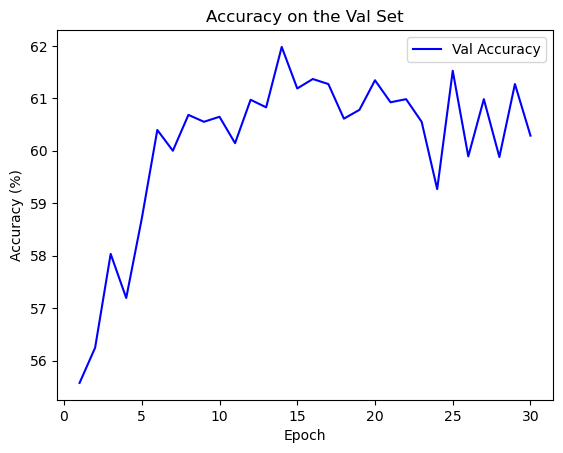

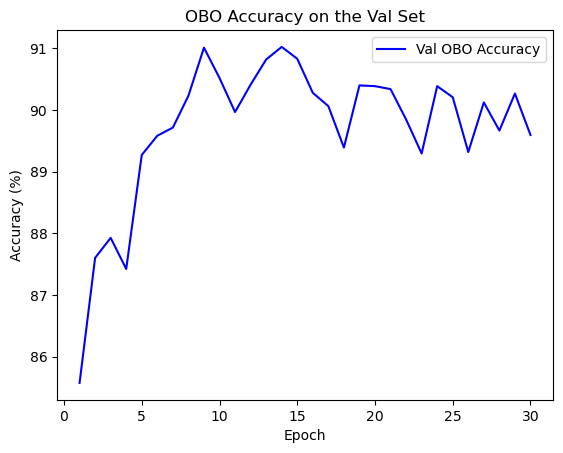

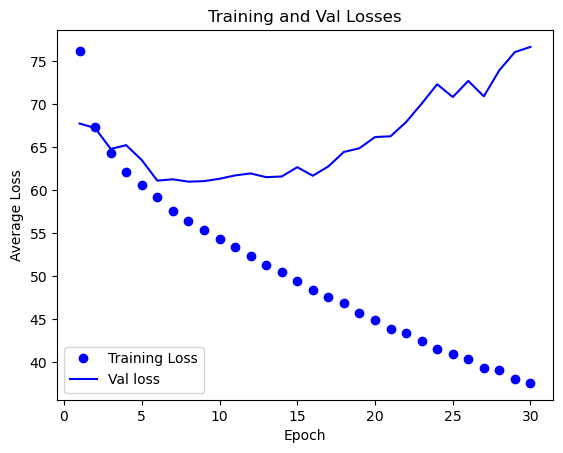

In [13]:
# Plot curves.
plt.plot(epoch_list, val_accs, 'b', label='Val Accuracy')
plt.title('Accuracy on the Val Set')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.figure()

plt.plot(epoch_list, val_obo_accs, 'b', label='Val OBO Accuracy')
plt.title('OBO Accuracy on the Val Set')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.figure()

plt.plot(epoch_list, [batch_size*loss for loss in train_losses], 'bo', label='Training Loss')
plt.plot(epoch_list, [batch_size*loss for loss in val_losses], 'b', label='Val loss')
plt.title('Training and Val Losses')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()

plt.show()

In [48]:
# TEST SETS
model_name = 'RepeatVeryNoisy'
test_set_name = 'RepeatVeryNoisy'

In [ ]:
#create embeddings for test set (if not already created)
input_dir = f'/scratch/local/ssd/hani/{test_set_name}'
test_data  = SpectrogramNPYDataset(input_dir + "/test/", transform=transform)
compute_embeddings(test_data, "test", testset_name=test_set_name)


In [47]:
print(f"Testing model: {model_name} on test set: {test_set_name}")

model = NeuralNet(in_features=384, out_features=9)
model.load_state_dict(torch.load(f"models/{model_name}/model_{model_name}.pth", map_location="cpu"))
model.to(device)
model.eval()

test_loader = torch.utils.data.DataLoader(
    Dinov2Spectrogram(split="test", root_dir=f'/scratch/local/ssd/hani/{test_set_name}', model = test_set_name, output_dir=output_dir),
    batch_size=1, shuffle=False)

test_loss = 0
correct = 0
obo_correct = 0
mae_sum = 0.0
for data, target in test_loader:
    data, target = data.cuda(), target.cuda()
    with torch.inference_mode():
        output = model(data)
    test_loss += F.nll_loss(output, target, size_average=False).item() # sum up batch loss
    pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
    correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    obo_correct += (np.abs(pred.cpu().numpy().flatten() -
                    target.cpu().numpy().flatten()) <= 1).sum()

    # accumulate NORMALISED absolute error (per-sample)
    denom = torch.clamp(target.view_as(pred).float(), min=1.0)
    mae_sum += (torch.abs(pred - target.view_as(pred)).float() / denom).cpu().sum().item()


test_loss /= len(test_loader.dataset)

acc = 100. * correct / len(test_loader.dataset)
obo_acc = 100. * obo_correct / len(test_loader.dataset)
mae = mae_sum / len(test_loader.dataset)

print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%), OBO Accuracy: ({:.3f}%), MAE: {:.4f}\n'.format(
    test_loss, int(correct), len(test_loader.dataset), acc, obo_acc, mae))

Testing model: RepeatVeryNoisy on test set: RepeatSoundNoisy


/tmp/ipykernel_835595/768013542.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"models/{model_name}/model_{model_name}.pth", map_locat


Test set: Average loss: 0.7797, Accuracy: 14104/20462 (68.928%), OBO Accuracy: (95.010%), MAE: 0.0909

